In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/data/23x project/Training Data.csv', index_col=0)



---
#feature

*   Income: 사용자의 소득
*   Age: 사용자의 나이
*   Experience: 전문적 경력 년수
*   Married/Single: 기혼/미혼
*   House_Ownership: 집 소유권
*   Car_Ownership: 차 소유권
*   Profession: 직업
*   CITY: 거주 도시
*   STATE: 거주 국가
*   CURRENT_JOB_YRS: 현재 근무 년수
*   CURRENT_HOUSE_YRS: 현재 거주 년수




---









In [3]:
# 결측치 확인
train.isnull().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [4]:
train.shape

(252000, 12)

In [5]:
# 데이터 타입 확인
train.dtypes

Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [6]:
train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


In [7]:
# feature의 category 확인
train.describe(exclude='number').T

,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


---
#data cleaning
*   Income: 사용자의 소득 / 그대로 사용
*   Age: 사용자의 나이 / 그대로 사용 or 모델 성능 보고 카테고리로 변화
*   Experience: 전문적 경력 년수 / 그대로 사용 or 모델 성능 보고 카테고리로 변화
*   Married/Single: 기혼/미혼 / 그대로 사용
*   House_Ownership: 집 소유권 / 그대로 사용
*   Car_Ownership: 차 소유권 / 그대로 사용
*   Profession: 직업 / category 수가 많아 삭제
*   CITY: 거주 도시 / category 수가 많아 삭제
*   STATE: 거주 주 / category 수가 많아 삭제
*   CURRENT_JOB_YRS: 현재 근무 년수 / 그대로 사용
*   CURRENT_HOUSE_YRS: 현재 거주 년수 / 그대로 사용


---



In [7]:
def wrangling(df):
  df = df.drop(labels=['Profession', 'CITY', 'STATE'], axis=1)
  return df

train = wrangling(train)

In [8]:
from sklearn.model_selection import train_test_split

target = 'Risk_Flag'

# 훈련/검증 데이터셋 나누기
# 데이터 셋이 충분히 크므로 hold-out 교차검증을 사용
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train[target], random_state=2)

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

y_train = train[target]
y_val = val[target]

In [9]:
# 기준모델 설정
y_train.value_counts(normalize=True)

0    0.876999
1    0.123001
Name: Risk_Flag, dtype: float64

In [11]:
#pip install category_encoders

     |████████████████████████████████| 82 kB 321 kB/s 


In [10]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimatores=200, random_state=2, n_jobs=-1, max_depth=5, learning_rate=0.2)
)

pipe.fit(X_train, y_train);

In [11]:
from sklearn.metrics import accuracy_score

y_pred = pipe.predict(X_val)
accuracy_score(y_val, y_pred)

0.879702380952381

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
dists = {
    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__n_estimators': [200, 500, 1000]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions = dists,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train);

The total space of parameters 45 is smaller than n_iter=50. Running 45 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 98.7min finished


In [ ]:
search.best_params_, search.best_score_

({'xgbclassifier__learning_rate': 0.2,
  'xgbclassifier__max_depth': 7,
  'xgbclassifier__n_estimators': 1000},
 0.8969494047619048)

In [12]:
# 튜닝한 하이퍼파라미터를 적용한 모델
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimatores=1000, random_state=2, n_jobs=-1, max_depth=7, learning_rate=0.2)
)

pipe.fit(X_train, y_train);

In [13]:
y_pred = pipe.predict(X_val)
accuracy_score(y_val, y_pred)

0.8844444444444445

In [14]:
# 교차 검증을 통해 일반화 가능성 확인
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='accuracy')

scores

array([0.88485119, 0.88360119, 0.88401786])

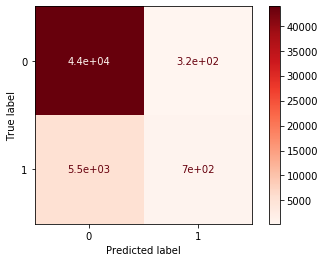

In [15]:
# 모델 성능
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap = plt.cm.Reds,
                            ax=ax);
plt.show()

In [16]:
# precision, recall
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     44201
           1       0.68      0.11      0.19      6199

    accuracy                           0.88     50400
   macro avg       0.79      0.55      0.57     50400
weighted avg       0.86      0.88      0.85     50400



In [17]:
# 이 모델은 채무 불이행 가능성이 있는 고객들을 가리는 것이 목적이기 때문에 recall 값이 높은 것이 좋지만
# 분류 레포트를 보면 대부분을 채무 이행을 한다는 것으로 예측하여 채무 불이행에 대한 recall 값이 낮다.
# 임계값을 설정하여 다시 예측.

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.08127885, 0.04505807, 0.03793154, ..., 0.12015766, 0.04019015,
       0.07359495], dtype=float32)

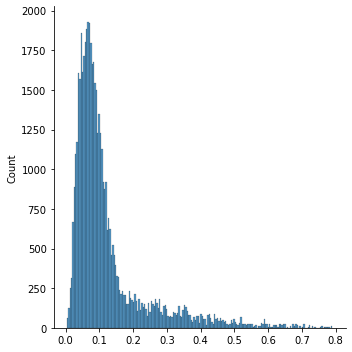

In [18]:
import seaborn as sns

sns.displot(y_pred_proba);

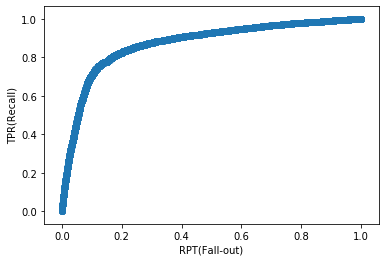

In [19]:
# 지금은 임계값을 0.5를 기준으로 분류하여 모두 채무 이행을 하는 것으로 예측.
# 임계값 조정의 필요성.

from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr)
plt.xlabel('RPT(Fall-out)')
plt.ylabel('TPR(Recall)');

In [20]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]

optimal_threshold

0.14775074

In [21]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     44201
           1       0.45      0.77      0.57      6199

    accuracy                           0.86     50400
   macro avg       0.71      0.82      0.74     50400
weighted avg       0.90      0.86      0.87     50400



In [22]:
accuracy_score(y_val, y_pred_optimal)

0.8554960317460317

In [23]:
#pip install eli5

In [24]:
# 순열 중요도
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['xgbclassifier'],
    scoring='accuracy',
    n_iter=5,
    random_state=2
)

X_val_transformed = pipe.named_steps['ordinalencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [25]:
feature_names = list(X_val.columns)
importance = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
importance

Income               0.008206
Age                  0.006667
Experience           0.006250
CURRENT_HOUSE_YRS    0.003095
CURRENT_JOB_YRS      0.002722
Car_Ownership        0.001135
House_Ownership      0.000694
Married/Single       0.000437
dtype: float64

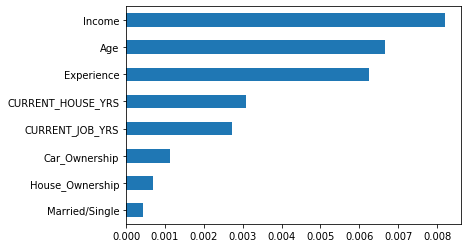

In [26]:
importance.sort_values().plot.barh();

In [28]:
#pip install pdpbox

     |████████████████████████████████| 34.0 MB 45 kB/s 
     |████████████████████████████████| 13.1 MB 7.1 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=37ccfec8dec0ca80cef698d9e81790ee5fc88d68f49566d30ffc824ca5281027
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


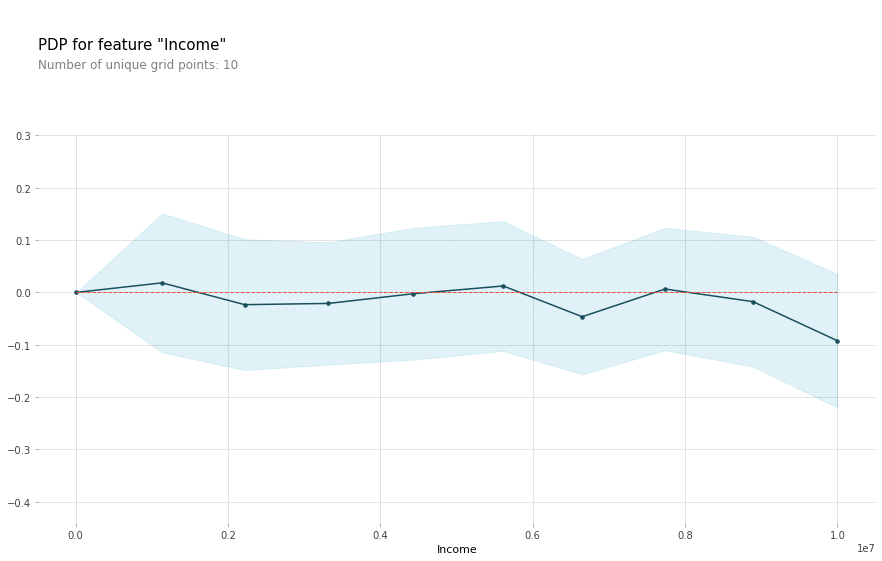

In [60]:
# 시각화
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Income'

pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

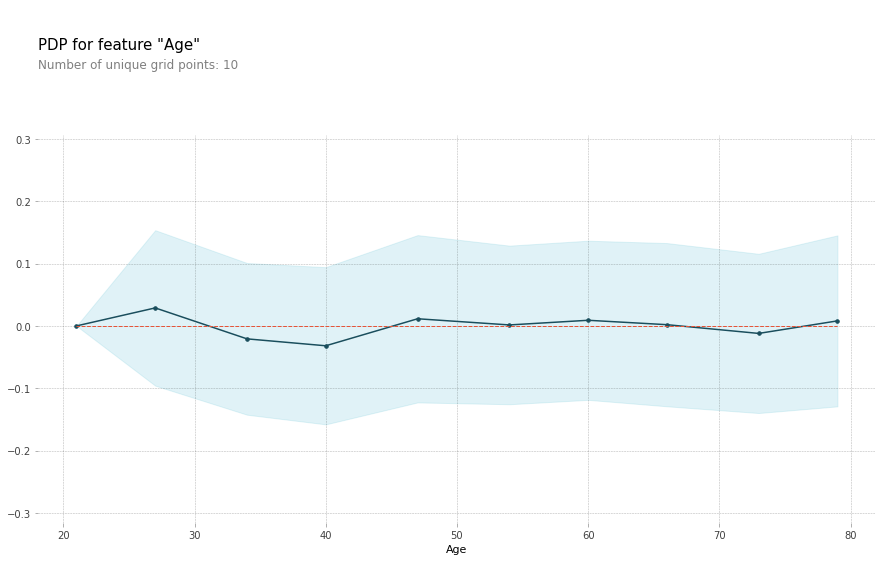

In [61]:
feature = 'Age'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

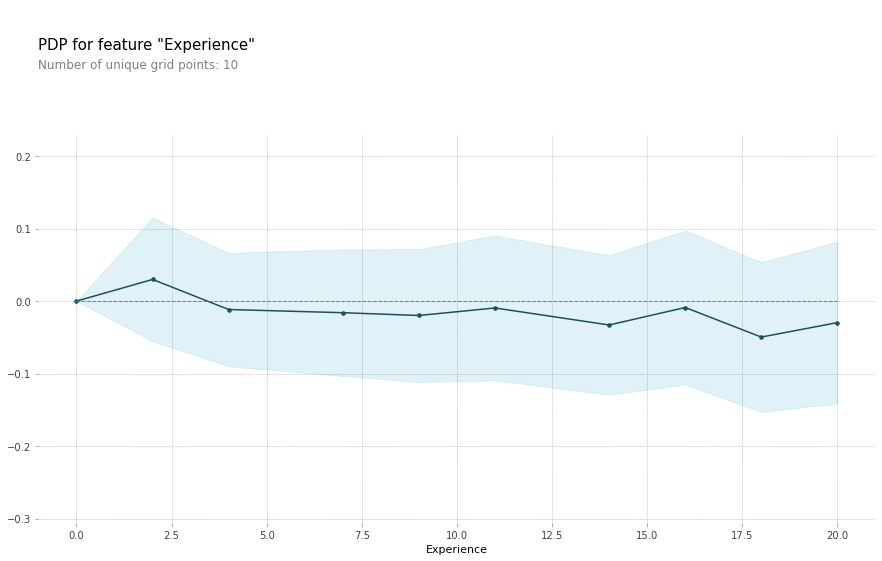

In [62]:
feature = 'Experience'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

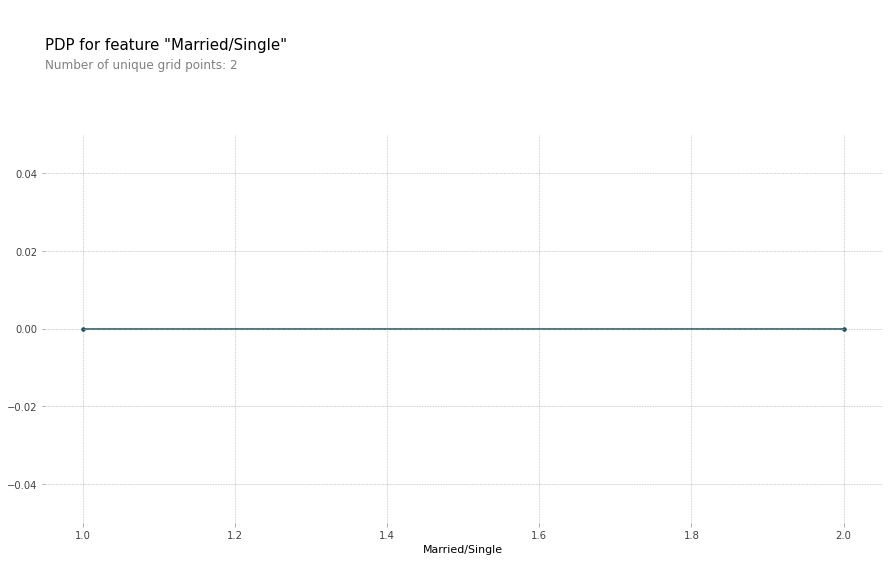

In [57]:
# single 1 / married 2
feature = 'Married/Single'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

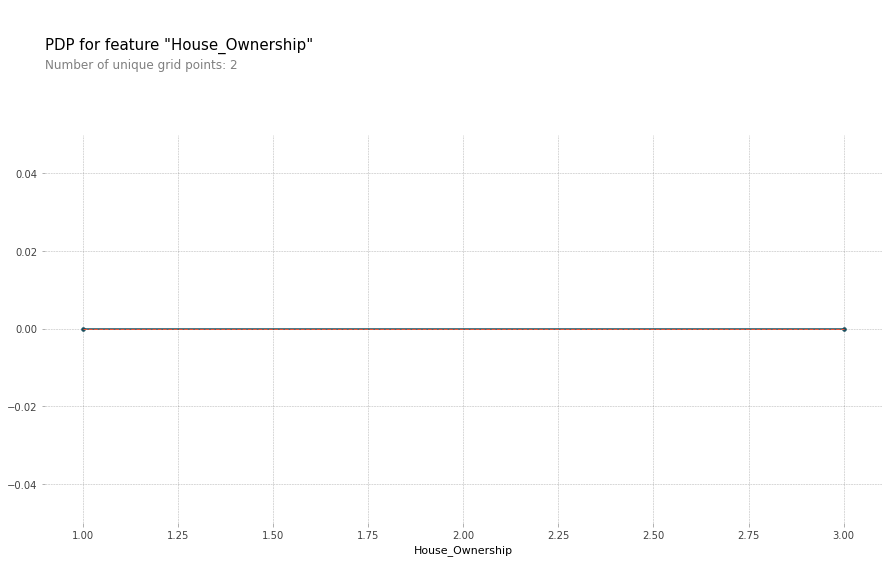

In [63]:
# rented1 / owned 2 / norent_noown 3
feature = 'House_Ownership'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

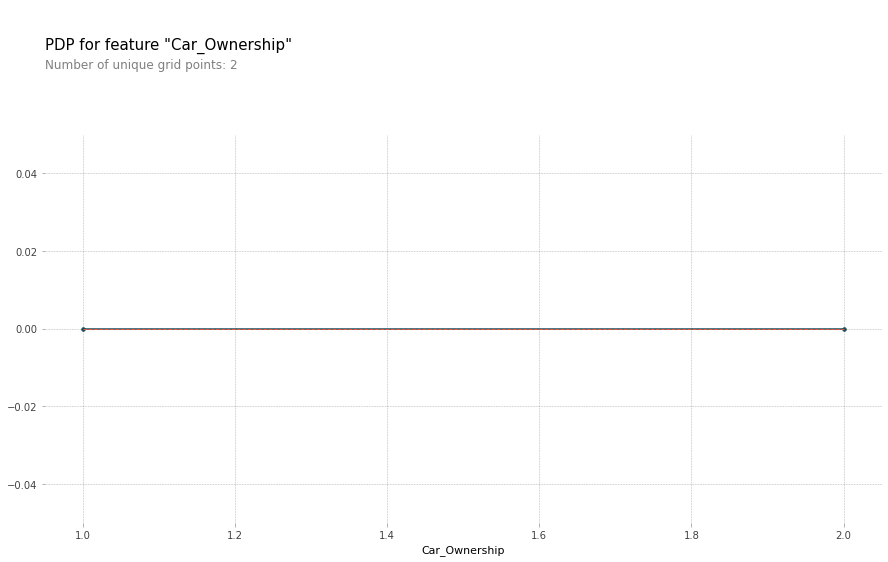

In [64]:
# no 1 / yes 2
feature = 'Car_Ownership'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

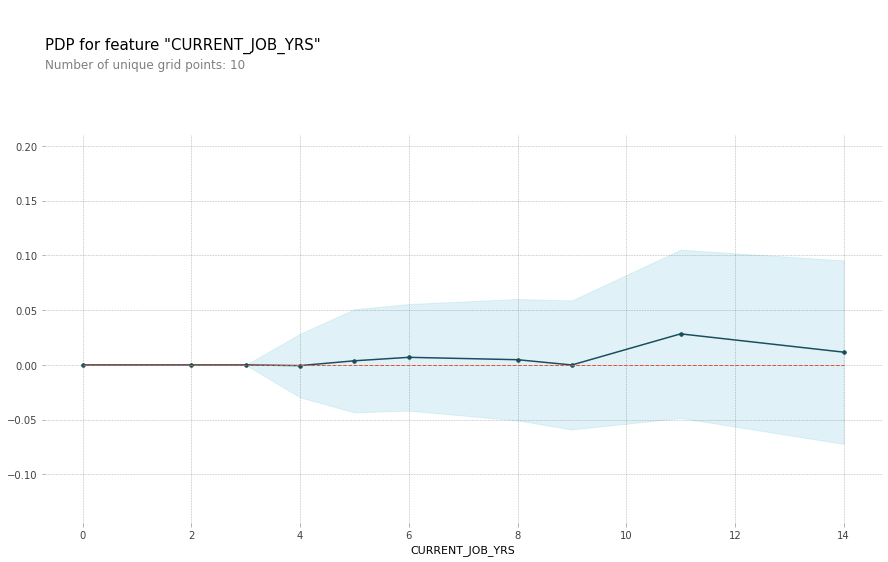

In [65]:
feature = 'CURRENT_JOB_YRS'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

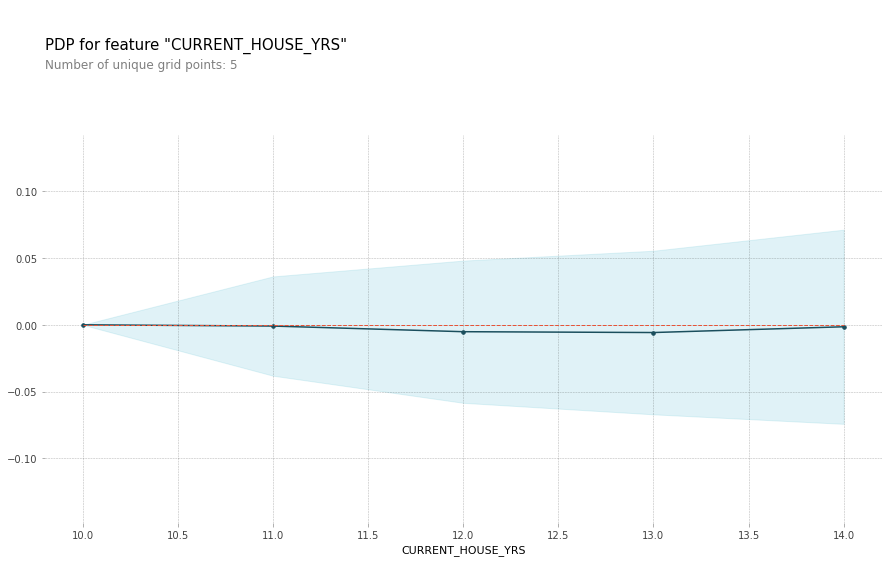

In [66]:
feature = 'CURRENT_HOUSE_YRS'
pdp = pdp_isolate(model=pipe, dataset=X_val_transformed, model_features = X_val.columns, feature = feature)

pdp_plot(pdp, feature_name=feature);

In [67]:
#pip install shap

     |████████████████████████████████| 371 kB 12.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509228 sha256=d4072acf0ebfa4948aa8764ef5a6efd6ccc098f8b36c094a3709798e0d325f22
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [30]:
# shap
import shap

pipe.named_steps
explainer = shap.TreeExplainer(pipe.named_steps['xgbclassifier'])

shap_values = explainer.shap_values(X_val_transformed[:300])

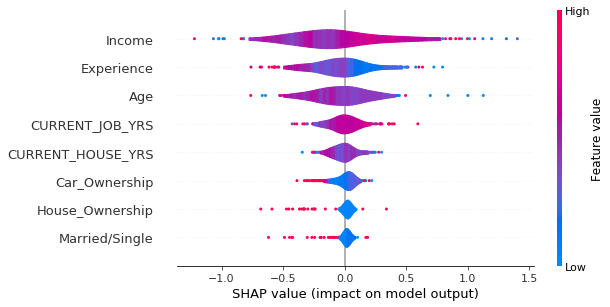

In [42]:
shap.initjs()
shap.summary_plot(shap_values, X_val_transformed[:300], plot_type='violin')